# This is a tutorial of using spaVAE for the spatial interpolation experiment of the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = "auto"
        self.maxiter = 5000
        self.train_size = 0.95
        self.patience = 200
        self.mask_prob = 0.1    # set mask probability, which means masking 0.1 random spots
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.GP_dim = 2
        self.Normal_dim = 8
        self.decoder_layers = [128]
        self.init_beta = 10
        self.min_beta = 4
        self.max_beta = 25
        self.KL_loss = 0.025
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.train_final_latent_file = "train_final_latent.txt"
        self.train_denoised_counts_file = "train_denoised_counts.txt"
        self.test_final_latent_file = "test_final_latent.txt"
        self.test_denoised_counts_file = "test_denoised_counts.txt"
        self.num_denoise_samples = 10000
        self.device = "cpu"

args = Args()

Setup inducing points, split training and testing sets, preprocess count matrix, and build the spaVAE model.

In [3]:
data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
data_mat.close()

if args.batch_size == "auto":
    if x.shape[0] <= 1024:
        args.batch_size = 128
    elif x.shape[0] <= 2048:
        args.batch_size = 256
    else:
        args.batch_size = 512
else:
    args.batch_size = int(args.batch_size)

print(args)


if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

sample_idx = np.arange(x.shape[0])
np.random.shuffle(sample_idx)
train_idx, test_idx = sample_idx[int(args.mask_prob*x.shape[0]):], sample_idx[:int(args.mask_prob*x.shape[0])]
np.savetxt(args.data_file[:-3]+"_train_index.txt", train_idx, delimiter=",", fmt="%i")
np.savetxt(args.data_file[:-3]+"_test_index.txt", test_idx, delimiter=",", fmt="%i")
x_train, x_test = x[train_idx], x[test_idx]
loc_train, loc_test = loc[train_idx], loc[test_idx]
print(x_train.shape, x_test.shape)
print(loc_train.shape, loc_test.shape)

adata_train = sc.AnnData(x_train, dtype="float64")

adata_train = normalize(adata_train,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

adata_test = sc.AnnData(x_test)

model = SPAVAE(input_dim=adata_train.n_vars, GP_dim=args.GP_dim, Normal_dim=args.Normal_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata_train.n_obs, KL_loss=args.KL_loss, init_beta=args.init_beta, min_beta=args.min_beta, 
    max_beta=args.max_beta, dtype=torch.float64, device=args.device)

print(str(model))

(3639, 3000)
(3639, 2)
(49, 2)
(3276, 3000) (363, 3000)
(3276, 2) (363, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=3000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=10, bias=True)
    (enc_var): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (dec_mean): Sequential(
    (0): Linear(in_features=128, out_features=3000, bias=True)
    (1): MeanAct()

Then train the spaVAE model

In [4]:
if not os.path.isfile(args.model_file):
    t0 = time()
    model.train_model(pos=loc_train, ncounts=adata_train.X, raw_counts=adata_train.raw.X, size_factors=adata_train.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            train_size=args.train_size, maxiter=args.maxiter, patience=args.patience, save_model=True, model_weights=args.model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(args.model_file)

final_latent = model.batching_latent_samples(X=loc_train, Y=adata_train.X, batch_size=args.batch_size)
np.savetxt(args.train_final_latent_file, final_latent, delimiter=",")


denoised_counts = model.batching_denoise_counts(X=loc_train, Y=adata_train.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.train_denoised_counts_file, denoised_counts, delimiter=",")

test_latent, test_denoised_counts = model.batching_predict_samples(X_test=loc_test, X_train=loc_train, Y_train=adata_train.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.test_final_latent_file, test_latent, delimiter=",")
np.savetxt(args.test_denoised_counts_file, test_denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:4411.50554640, NB loss:4393.53125780, GP KLD loss:0.03277343, Gaussian KLD loss:1.74851497, noise regularization:0.000000
Current beta 10.224420723517277
Current kernel scale tensor([20.0058])
Training epoch 1, validating ELBO:4336.48532443
Training epoch 2, ELBO:4198.53785901, NB loss:4177.89512314, GP KLD loss:0.03426325, Gaussian KLD loss:1.96512921, noise regularization:0.000000
Current beta 10.467793388619864
Current kernel scale tensor([20.0119])
Training epoch 2, validating ELBO:4136.28539273
Training epoch 3, ELBO:4010.89430426, NB loss:3986.08955525, GP KLD loss:0.03652962, Gaussian KLD loss:2.30778653, noise regularization:0.000000
Current beta 10.741094275028498
Current kernel scale tensor([20.0183])
Training epoch 3, validating ELBO:3962.80218947
Training epoch 4, ELBO:3855.32576164, NB loss:3829.21284589, GP KLD loss:0.04081961, Gaussian KLD loss:2.36185441, noise regularization:0.000000
Current beta 11.056164144749005
Current kernel scale t

Plot results in R and ggplot2.

Using 11-nearest neighbors predictor to predict labels of testing set.

In [1]:
rm(list=ls())
library(class)
library(rhdf5)
library(ggplot2)
library(umap)
library(scater)

train.embedding <- read.table("train_final_latent.txt", sep=",")
train.idx <- as.numeric(readLines("sample_151673_train_index.txt"))+1
test.embedding <- read.table("test_final_latent.txt", sep=",")
test.idx <- as.numeric(readLines("sample_151673_test_index.txt"))+1

Y <- h5read("sample_151673.h5", "Y")
na.idx <- which(is.na(Y))

no.na.train.idx <- ! (train.idx %in% na.idx)
no.na.test.idx <- ! (test.idx %in% na.idx)

test.knn <- knn(train.embedding[no.na.train.idx,], test.embedding[no.na.test.idx,], Y[train.idx[no.na.train.idx]], k=11)
test.acc <- mean(test.knn == Y[test.idx[no.na.test.idx]])

print("Testing 11-NN accurarcy")
print(test.acc)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.1”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumE

[1] "Testing 11-NN accurarcy"
[1] 0.9305556


Plot the spaVAE latent embedding of training and testing sets.

Warning message:
“Using alpha for a discrete variable is not advised.”


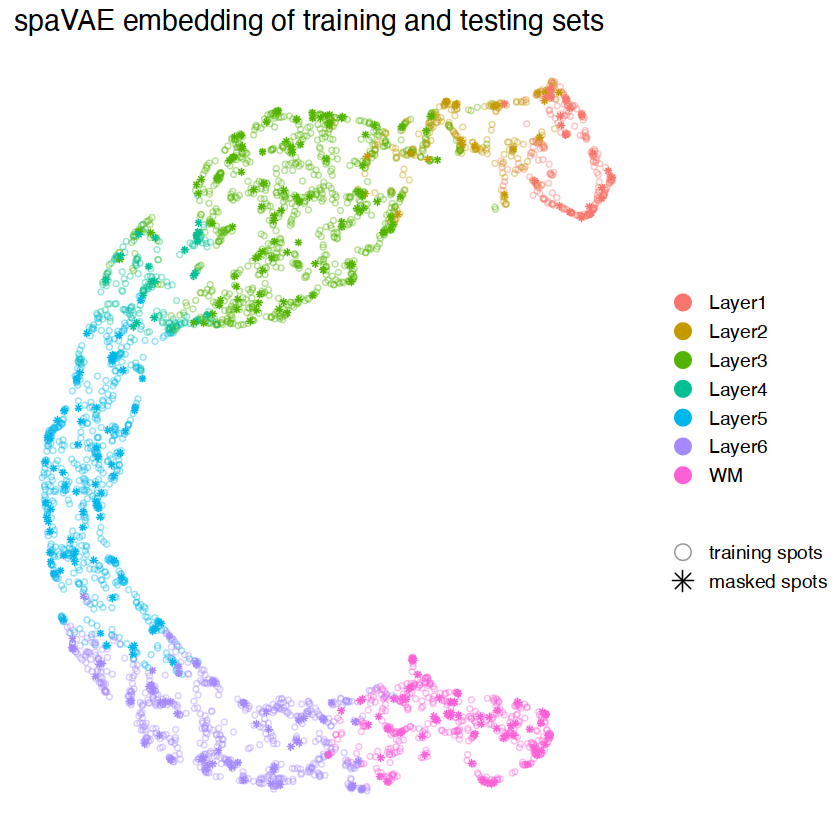

In [2]:
embedding <- rbind(train.embedding, test.embedding)
embedding_umap <- umap(embedding, method="naive", preserve.seed=T)

dat <- data.frame(embedding_umap$layout, Y=c(Y[train.idx], Y[test.idx]),
                data=c(rep("training spots", nrow(train.embedding)), rep("masked spots", nrow(test.embedding))))
dat$data <- factor(dat$data, levels=c("training spots", "masked spots"))

ggplot(subset(dat, !is.na(Y)), aes(x=X1, y=X2, color=Y, shape=data, alpha=data)) + geom_point(size=1) + 
ggtitle("spaVAE embedding of training and testing sets") +
scale_shape_manual(values=c(1, 8)) + scale_alpha_discrete(range=c("training spots"=0.4, "masked spots"=1)) + theme_classic() + 
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank(), text = element_text(size=14)) +
guides(colour = guide_legend(override.aes = list(size=4)), shape = guide_legend(override.aes = list(size=4)))

Plot spaVAE interpolated counts of marker genes.

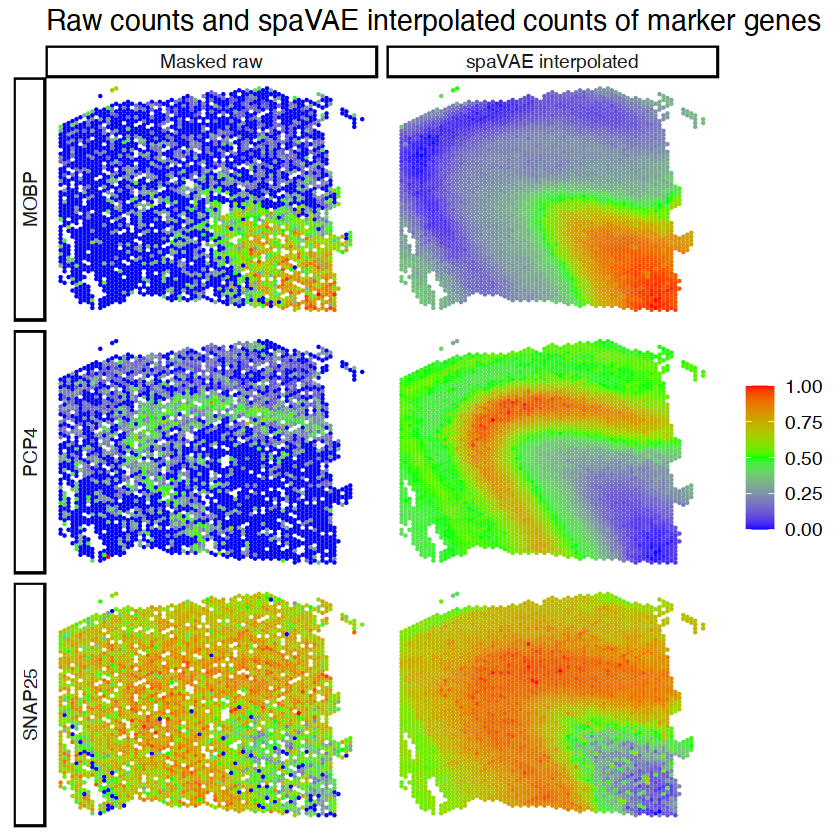

In [3]:
pos <- t(h5read("sample_151673.h5", "pos"))
pos <- data.frame(pos)
colnames(pos) <- c("x", "y")
raw.counts <- h5read("sample_151673.h5", "X")
gene <- h5read("sample_151673.h5", "gene")
cell <- h5read("sample_151673.h5", "cell")
rownames(pos) <- cell

sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- gene
colnames(sce) <- cell
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- t(apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

                        
train_counts <- read.table("train_denoised_counts.txt", sep=",")
train_idx <- as.numeric(readLines("sample_151673_train_index.txt"))+1
rownames(train_counts) <- train_idx
colnames(train_counts) <- gene

logtraincounts <- log(train_counts)
logtraincounts <- t(apply(logtraincounts, 2, function(z) scales::rescale(z, to=c(0,1))))

test_counts <- read.table("test_denoised_counts.txt", sep=",")
test_idx <- as.numeric(readLines("sample_151673_test_index.txt"))+1
rownames(test_counts) <- test_idx
colnames(test_counts) <- gene

combine_counts <- rbind(train_counts, test_counts)
colnames(combine_counts) <- gene

logcombinecounts <- log(combine_counts)
logcombinecounts <- t(apply(logcombinecounts, 2, function(z) scales::rescale(z, to=c(0,1))))

combine_idx <- c(train_idx, test_idx)

interpolate.raw.dat <- data.frame(exp=c(lograwcounts["ENSG00000168314",train_idx], lograwcounts["ENSG00000183036",train_idx],
                                 lograwcounts["ENSG00000132639",train_idx]),
                           gene=rep(c("MOBP", "PCP4", "SNAP25"), each=ncol(lograwcounts[,train_idx])),
                           x=rep(pos[train_idx, "x"], 3), y=rep(pos[train_idx, "y"], 3), data="Masked raw")
interpolate.combine.dat <- data.frame(exp=c(logcombinecounts["ENSG00000168314",], logcombinecounts["ENSG00000183036",],
                                     logcombinecounts["ENSG00000132639",]),
                               gene=rep(c("MOBP", "PCP4", "SNAP25"), each=ncol(logcombinecounts)),
                               x=rep(pos[combine_idx, "x"], 3), y=rep(pos[combine_idx, "y"], 3), data="spaVAE interpolated")
interpolate.dat <- rbind(interpolate.raw.dat, interpolate.combine.dat)
interpolate.dat$gene <- factor(interpolate.dat$gene, levels=c("MOBP", "PCP4", "SNAP25"))

ggplot(interpolate.dat, aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
facet_grid(gene~data, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
ggtitle("Raw counts and spaVAE interpolated counts of marker genes") + theme_classic() + 
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank(), text = element_text(size=14))